# Setup

In [1]:
# standard library imports
import time

# third party library imports
import numpy as np
import optuna
import pandas as pd

# machine learning imports
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    TargetEncoder,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# local imports
from utils import (
    plot_confusion_matrix,
    plot_correlation_heatmap,
    plot_feature_distributions,
    plot_model_metrics,
    plot_predictions,
    plot_probability_distribution,
    plot_target_correlations,
    validate_train_test_distribution,
)

In [2]:
# patch sklearn for performance boost
from sklearnex import patch_sklearn

patch_sklearn(verbose=False)

# EDA

In [3]:
# load data
index_col = "id"
train_data = pd.read_csv("train.csv", index_col=index_col)
test_data = pd.read_csv("test.csv", index_col=index_col)
sub_data = pd.read_csv("sample_submission.csv", index_col=index_col)

In [4]:
# preview data
train_data

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,D-penicillamine,16839,F,N,N,N,N,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,C
7901,1492,Placebo,17031,F,N,Y,N,N,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7902,1576,D-penicillamine,25873,F,N,N,Y,S,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,D


In [5]:
# check data types
train_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   str    
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   str    
 4   Ascites        7905 non-null   str    
 5   Hepatomegaly   7905 non-null   str    
 6   Spiders        7905 non-null   str    
 7   Edema          7905 non-null   str    
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status         7905

In [6]:
# check for missing values in each column
train_data.isna().sum().sort_values(ascending=False)

N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [7]:
# check for unique values
train_data.nunique()

N_Days           461
Drug               2
Age              391
Sex                2
Ascites            2
Hepatomegaly       2
Spiders            2
Edema              3
Bilirubin        111
Cholesterol      226
Albumin          160
Copper           171
Alk_Phos         364
SGOT             206
Tryglicerides    154
Platelets        227
Prothrombin       49
Stage              4
Status             3
dtype: int64

In [8]:
# set target and classes
target = "Status"
train_data[target] = train_data[target].map(lambda x: "Status_" + x)
target_classes = ["Status_C", "Status_D", "Status_CL"]
train_data[target].value_counts() * 100 / len(train_data)

Status
Status_C     62.808
Status_D     33.713
Status_CL     3.479
Name: count, dtype: float64

In [9]:
# set features
numerical_features = [
    "Age",
    "Albumin",
    "Alk_Phos",
    "Bilirubin",
    "Cholesterol",
    "Copper",
    "N_Days",
    "Platelets",
    "Prothrombin",
    "SGOT",
    "Tryglicerides",
]

nominal_features = [
    "Edema",
    "Stage",
]
ordinal_features = [
    "Ascites",
    "Drug",
    "Hepatomegaly",
    "Sex",
    "Spiders",
]

categorical_features = nominal_features + ordinal_features
features = numerical_features + categorical_features

plot_features = sorted(features)
corr_features = [target] + sorted(numerical_features + ordinal_features)


In [10]:
# use copies for exploratory analysis
train_data_encoded = train_data.copy()
test_data_encoded = test_data.copy()

# encode target
target_encoder = LabelEncoder().fit(train_data[target])
train_data_encoded[target] = np.asarray(target_encoder.transform(train_data[target]))

# encode categorical features
feature_encoders = {}
for feature in categorical_features:
    encoder = OrdinalEncoder().fit(train_data[[feature]])
    train_data_encoded[feature] = encoder.transform(train_data[[feature]])
    test_data_encoded[feature] = encoder.transform(test_data[[feature]])
    feature_encoders[feature] = encoder

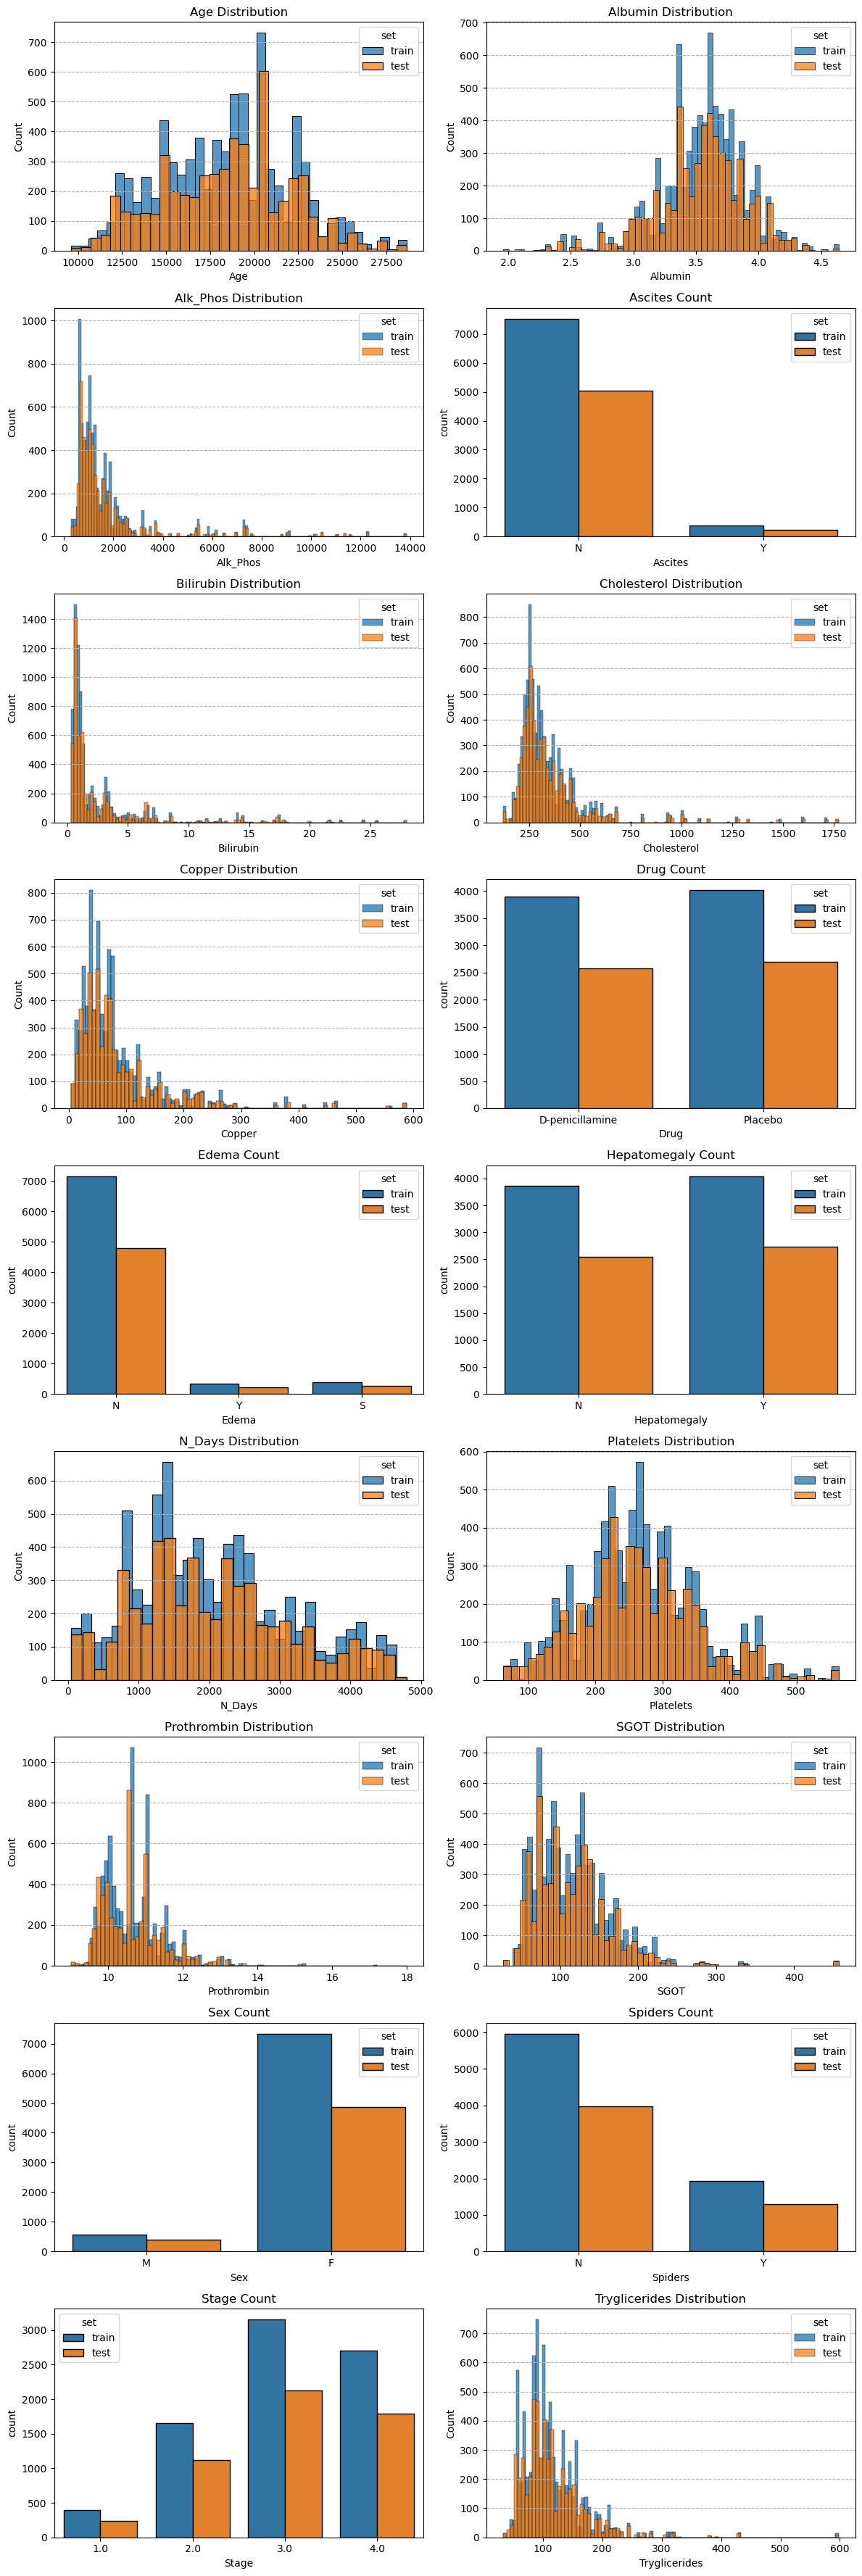

In [11]:
# plot features
plot_feature_distributions(
    train_data=train_data,
    test_data=test_data,
    features=plot_features,
    categorical_features=categorical_features,
)

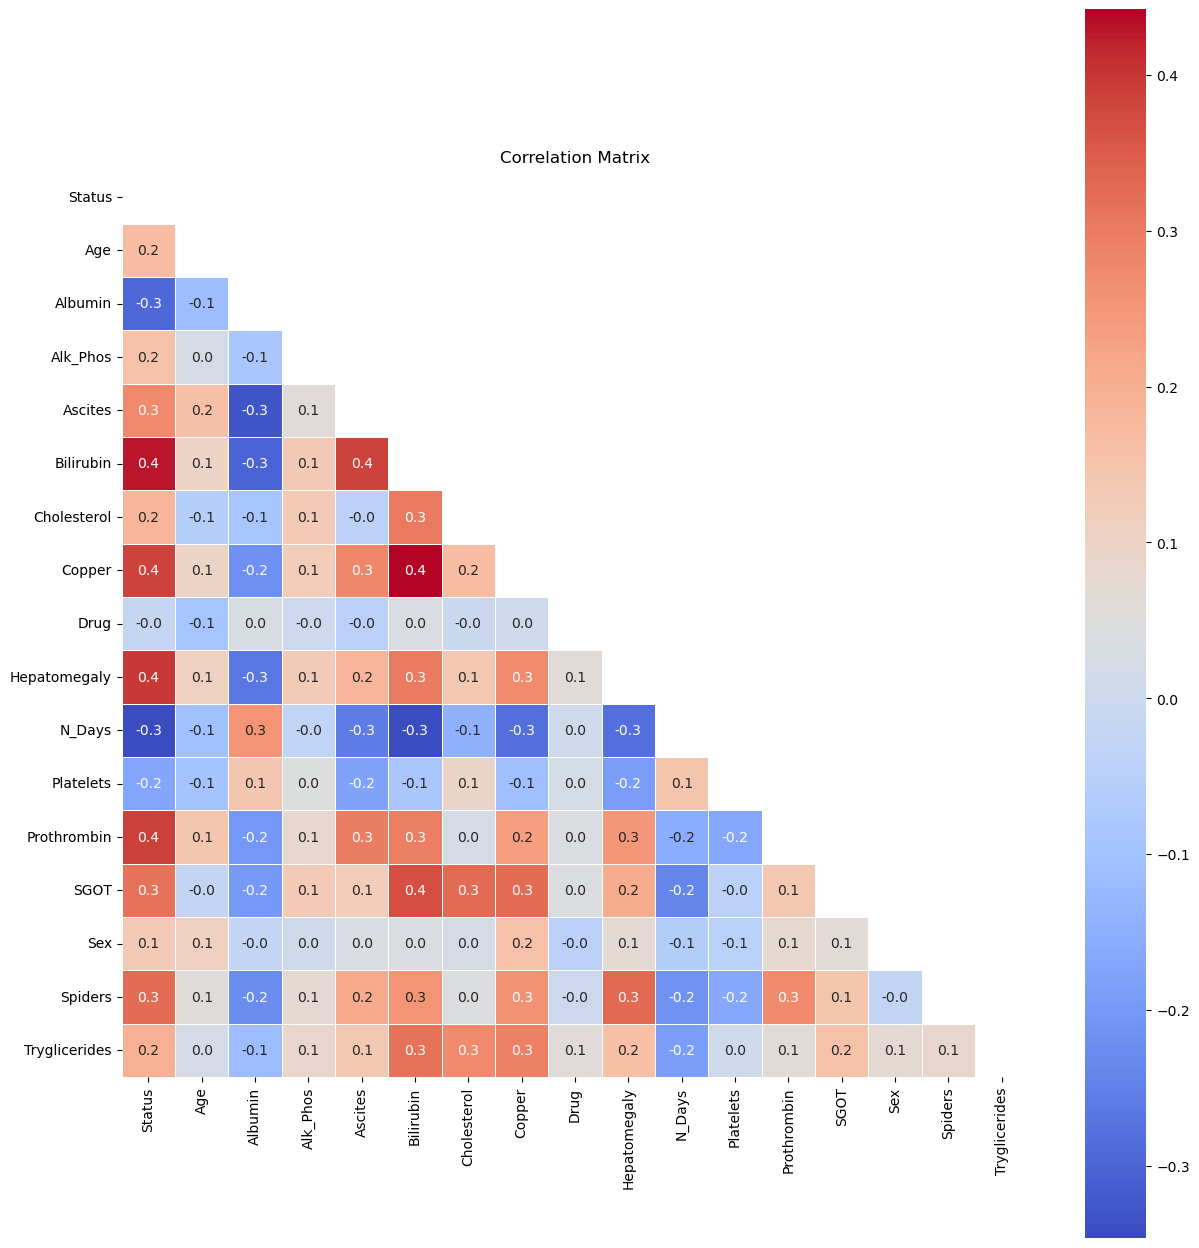

In [12]:
# plot correlations
plot_correlation_heatmap(train_data=train_data_encoded, features=corr_features)

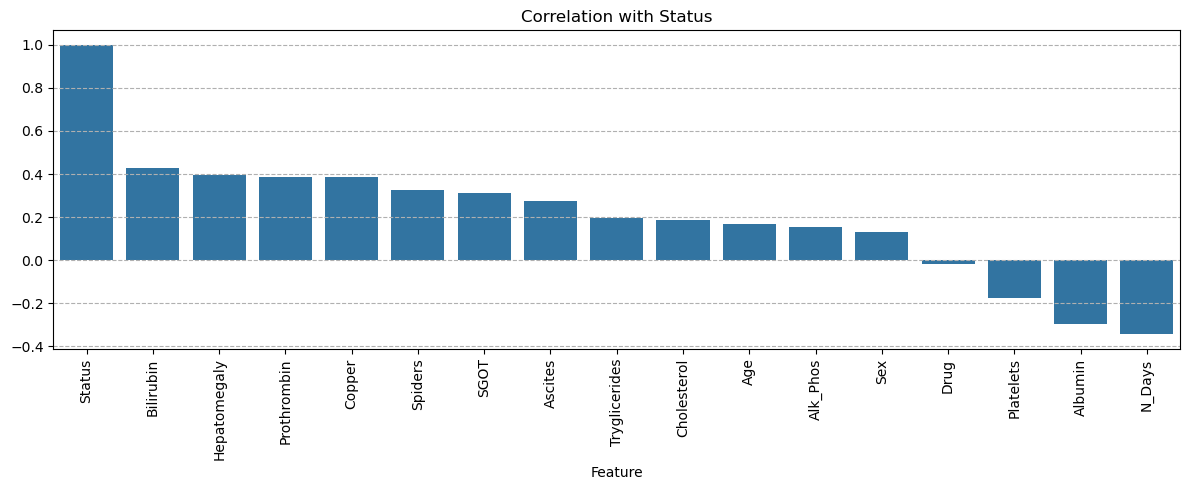

In [13]:
# plot target correlations
plot_target_correlations(
    train_data=train_data_encoded, target=target, features=corr_features
)

In [14]:
# validate that train and test sets have similar distributions
validate_train_test_distribution(
    train_data=train_data_encoded,
    test_data=test_data_encoded,
    features=plot_features,
    model=RandomForestClassifier(random_state=42, n_estimators=50),
    cv=5,
    threshold=0.6,
)

Validation score = 0.49 < threshold = 0.6 → train and test sets indistinguishable


# Data Preprocessing

In [15]:
# encode target
train_data[target] = train_data_encoded[target]

# split data into training and test sets
X = train_data[features]
y = train_data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
# define preprocessing columns and steps
transformer_config = {
    "numerical": {
        "columns": numerical_features,
        "steps": [("scale", RobustScaler())],
    },
    "nominal": {
        "columns": nominal_features,
        "steps": [
            ("encode", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
        ],
    },
    "ordinal": {
        "columns": ordinal_features,
        "steps": [
            (
                "encode",
                OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            )
        ],
    },
}

In [17]:
# build preprocessor
transformers = []
for feature_type, config in transformer_config.items():
    columns = config["columns"]
    steps = config["steps"]
    feature_pipeline = Pipeline(steps=steps)
    transformers.append((feature_type, feature_pipeline, columns))

preprocessor = ColumnTransformer(transformers=transformers)
preprocessor.set_output(transform="pandas")

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical', ...), ('nominal', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature

In [18]:
# define scoring metrics
metrics = {
    "accuracy": {
        "func": accuracy_score,
        "needs_proba": False,
    },
    "balanced_accuracy": {
        "func": balanced_accuracy_score,
        "needs_proba": False,
    },
    "f1_weighted": {
        "func": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
        "needs_proba": False,
    },
    "matthews_corrcoef": {
        "func": matthews_corrcoef,
        "needs_proba": False,
    },
    "neg_log_loss": {
        "func": lambda y_true, y_proba: -log_loss(y_true, y_proba),
        "needs_proba": True,
    },
    # binary
    # "roc_auc": {
    #     "func": lambda y_true, y_proba: roc_auc_score(y_true, y_proba[:, 1]),
    #     "needs_proba": True,
    # },
    # multiclass
    "roc_auc": {
        "func": lambda y_true, y_proba: roc_auc_score(
            y_true, y_proba, multi_class="ovr", average="weighted"
        ),
        "needs_proba": True,
    },
}

primary_metric = "neg_log_loss"

# Modelling

In [ ]:
# create models and parameter spaces
lr_solvers = ["liblinear", "lbfgs"] if len(target_classes) == 2 else ["lbfgs"]
models = {
    "lr": {
        "model": LogisticRegression(random_state=42, max_iter=10000),
        "params": {
            "lr__C": ("float", 1e-3, 1e3, {"log": True}),
            "lr__solver": ("categorical", lr_solvers, None, {}),
        },
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {
            "svc__C": ("float", 1e-3, 1e3, {"log": True}),
            "svc__kernel": ("categorical", ["linear", "rbf", "poly"], None, {}),
            "svc__gamma": ("float", 1e-4, 1e0, {"log": True}),
            "svc__degree": ("int", 2, 5, {}),
            "svc__coef0": ("float", 0.0, 1.0, {}),
        },
    },
    "rf": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "rf__n_estimators": ("int", 50, 500, {}),
            "rf__max_depth": ("int", 3, 20, {}),
            "rf__min_samples_split": ("int", 2, 20, {}),
            "rf__min_samples_leaf": ("int", 1, 10, {}),
            "rf__max_features": ("categorical", ["sqrt", "log2"], None, {}),
        },
    },
    "decision": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "decision__max_depth": ("int", 3, 20, {}),
            "decision__min_samples_split": ("int", 2, 20, {}),
            "decision__min_samples_leaf": ("int", 1, 10, {}),
            "decision__criterion": ("categorical", ["gini", "entropy"], None, {}),
        },
    },
    "xgb": {
        "model": XGBClassifier(random_state=42),
        "params": {
            "xgb__n_estimators": ("int", 100, 1000, {}),
            "xgb__max_depth": ("int", 3, 10, {}),
            "xgb__learning_rate": ("float", 1e-3, 0.3, {"log": True}),
            "xgb__subsample": ("float", 0.5, 1.0, {}),
            "xgb__colsample_bytree": ("float", 0.5, 1.0, {}),
            "xgb__min_child_weight": ("int", 1, 10, {}),
            "xgb__gamma": ("float", 1e-8, 1.0, {"log": True}),
        },
    },
    "lgb": {
        "model": LGBMClassifier(random_state=42, verbose=-1),
        "params": {
            "lgb__n_estimators": ("int", 100, 1000, {}),
            "lgb__num_leaves": ("int", 31, 128, {}),
            "lgb__learning_rate": ("float", 1e-3, 0.3, {"log": True}),
            "lgb__subsample": ("float", 0.5, 1.0, {}),
            "lgb__colsample_bytree": ("float", 0.5, 1.0, {}),
            "lgb__min_child_samples": ("int", 20, 200, {}),
            "lgb__reg_alpha": ("float", 1e-8, 10.0, {"log": True}),
            "lgb__reg_lambda": ("float", 1e-8, 10.0, {"log": True}),
        },
    },
    "gb": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "gb__n_estimators": ("int", 50, 500, {}),
            "gb__learning_rate": ("float", 1e-3, 0.3, {"log": True}),
            "gb__max_depth": ("int", 3, 10, {}),
            "gb__subsample": ("float", 0.5, 1.0, {}),
            "gb__min_samples_split": ("int", 2, 20, {}),
            "gb__min_samples_leaf": ("int", 1, 10, {}),
        },
    },
    "ada": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "ada__n_estimators": ("int", 50, 500, {}),
            "ada__learning_rate": ("float", 1e-3, 1.0, {"log": True}),
        },
    },
    "cat": {
        "model": CatBoostClassifier(
            random_state=42,
            verbose=0,
            bootstrap_type="Bernoulli",
            allow_writing_files=False,
        ),
        "params": {
            "cat__iterations": ("int", 100, 1000, {}),
            "cat__depth": ("int", 3, 10, {}),
            "cat__learning_rate": ("float", 1e-3, 0.3, {"log": True}),
            "cat__l2_leaf_reg": ("float", 1e-3, 10.0, {"log": True}),
            "cat__subsample": ("float", 0.5, 1.0, {}),
        },
    },
}

In [20]:
# train all models with default parameters on X_train
train_results_list = []
train_times = {}
pipelines = {}

cv_train = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model_config in models.items():
    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            (model_name, model_config["model"]),
        ]
    )

    start_time = time.time()
    search = GridSearchCV(
        estimator=pipeline,
        param_grid={},
        cv=cv_train,
        scoring=primary_metric,
        refit=True,
    )
    search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    cv_scores = {primary_metric: search.cv_results_["mean_test_score"][0]}
    cv_scores["model"] = model_name

    pipelines[model_name] = search.best_estimator_
    train_times[model_name] = elapsed_time
    train_results_list.append(cv_scores)

train_results = pd.DataFrame(train_results_list).set_index("model")
train_results = train_results.sort_values(primary_metric, ascending=False)
best_model_name = str(train_results[primary_metric].idxmax())
display(train_results)

,neg_log_loss
model,
gb,-0.455
cat,-0.483
lgb,-0.486
svc,-0.518
lr,-0.528
xgb,-0.540
rf,-0.551
ada,-1.004
decision,-9.587


In [21]:
# define objective function for tuning
def make_objective(model_name, cv, metric):
    def objective(trial):
        param_space = models[model_name]["params"]
        params = {}
        for param_name, spec in param_space.items():
            suggest_type, low, high, kwargs = spec
            if suggest_type == "int":
                params[param_name] = trial.suggest_int(param_name, low, high, **kwargs)
            elif suggest_type == "float":
                params[param_name] = trial.suggest_float(
                    param_name, low, high, **kwargs
                )
            elif suggest_type == "categorical":
                params[param_name] = trial.suggest_categorical(param_name, low)

        trial_pipeline = clone(pipelines[model_name])
        trial_pipeline.set_params(**params)

        scores = []
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            trial_pipeline.fit(X_fold_train, y_fold_train)
            if metrics[metric]["needs_proba"]:
                y_fold_pred = trial_pipeline.predict_proba(X_fold_val)
            else:
                y_fold_pred = trial_pipeline.predict(X_fold_val)
            scores.append(metrics[metric]["func"](y_fold_val, y_fold_pred))

        return sum(scores) / len(scores)

    return objective

In [22]:
# tune best model on X_train
cv_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tuned_start_time = time.time()

study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(
    make_objective(best_model_name, cv_tune, primary_metric),
    n_trials=50,
    show_progress_bar=True,
)

tuned_elapsed_time = time.time() - tuned_start_time

tuned_model_name = f"{best_model_name}_tuned"
tuned_params = study.best_params

tuned_pipeline = clone(pipelines[best_model_name])
tuned_pipeline.set_params(**tuned_params)
tuned_pipeline.fit(X_train, y_train)

pipelines[tuned_model_name] = tuned_pipeline
train_times[tuned_model_name] = tuned_elapsed_time

tune_results = train_results.loc[[best_model_name]].copy()
tune_results.loc[tuned_model_name] = {primary_metric: study.best_value}
tune_results = tune_results.sort_values(primary_metric, ascending=False)
display(tune_results)
display(tuned_params)

Best trial: 30. Best value: -0.450827: 100%|██████████| 50/50 [23:48<00:00, 28.58s/it]


,neg_log_loss
model,
gb_tuned,-0.451
gb,-0.455


{'gb__n_estimators': 220,
 'gb__learning_rate': 0.02224186989786955,
 'gb__max_depth': 5,
 'gb__subsample': 0.5303513264247236,
 'gb__min_samples_split': 11,
 'gb__min_samples_leaf': 2}

In [23]:
# evaluate all models on X_test
test_results_list = []
confusion_matrices = {}

for model_name, pipeline in pipelines.items():
    y_test_pred = pipeline.predict(X_test)
    y_test_pred_proba = pipeline.predict_proba(X_test)

    test_scores = {}
    for metric_name, metric_config in metrics.items():
        if metric_config["needs_proba"]:
            test_scores[metric_name] = metric_config["func"](y_test, y_test_pred_proba)
        else:
            test_scores[metric_name] = metric_config["func"](y_test, y_test_pred)

    test_scores["model"] = model_name
    test_results_list.append(test_scores)

    confusion_matrices[model_name] = confusion_matrix(y_test, y_test_pred)

test_results = pd.DataFrame(test_results_list).set_index("model")
test_results["train_time"] = pd.Series(train_times)
test_results = test_results.sort_values(primary_metric, ascending=False)

display(test_results)

,accuracy,balanced_accuracy,f1_weighted,matthews_corrcoef,neg_log_loss,roc_auc,train_time
model,,,,,,,
gb_tuned,0.842,0.623,0.833,0.673,-0.436,0.910,1428.872
gb,0.837,0.613,0.828,0.662,-0.439,0.909,13.064
lgb,0.838,0.627,0.830,0.665,-0.462,0.904,1.352
cat,0.832,0.612,0.824,0.653,-0.465,0.901,16.166
rf,0.829,0.590,0.818,0.645,-0.480,0.901,3.757
svc,0.815,0.545,0.798,0.613,-0.506,0.883,16.492
xgb,0.830,0.615,0.822,0.648,-0.508,0.899,4.612
lr,0.792,0.523,0.774,0.562,-0.526,0.872,3.207
ada,0.817,0.544,0.800,0.616,-1.003,0.881,1.404


In [24]:
# retrain tuned model on X_train and X_test
final_model = clone(tuned_pipeline)
final_model.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('gb', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical', ...), ('nominal', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tra

# Results

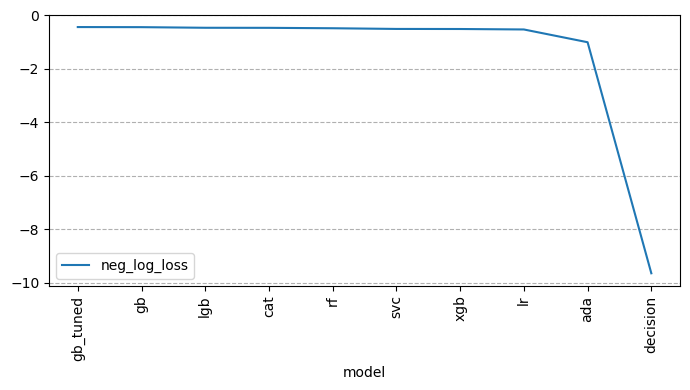

In [25]:
# plot initial results
plot_model_metrics(test_results, primary_metric)

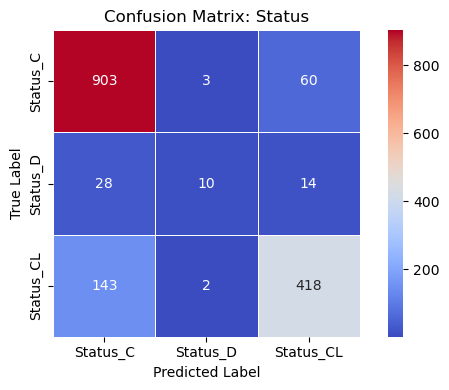

In [26]:
# plot confusion matrix
plot_confusion_matrix(
    cm=confusion_matrices[tuned_model_name],
    target=target,
    class_labels=target_classes,
)

In [27]:
# make predictions and probabilties
test_pred = final_model.predict(test_data)
test_pred_proba = final_model.predict_proba(test_data)
decoded_pred = target_encoder.inverse_transform(test_pred.ravel())

# write to submissions file
for i, cls in enumerate(target_encoder.classes_):
    sub_data[cls] = test_pred_proba[:, i]
sub_data.to_csv("submission.csv", index=True, index_label=index_col)
pd.read_csv("submission.csv")

,id,Status_C,Status_CL,Status_D
0,7905,0.683,0.026,0.292
1,7906,0.727,0.151,0.122
2,7907,0.067,0.064,0.869
3,7908,0.911,0.008,0.081
4,7909,0.767,0.041,0.193
...,...,...,...,...
5266,13171,0.891,0.032,0.077
5267,13172,0.955,0.006,0.039
5268,13173,0.883,0.008,0.109
5269,13174,0.976,0.006,0.018


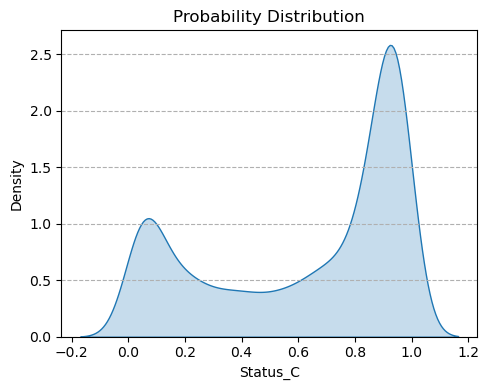

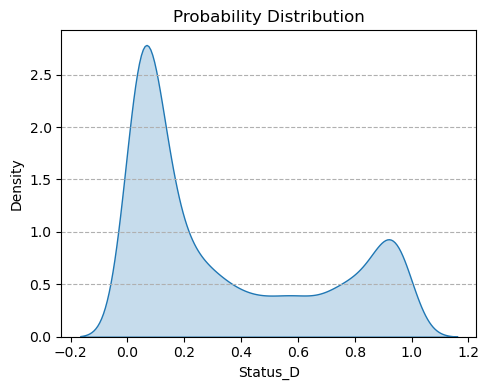

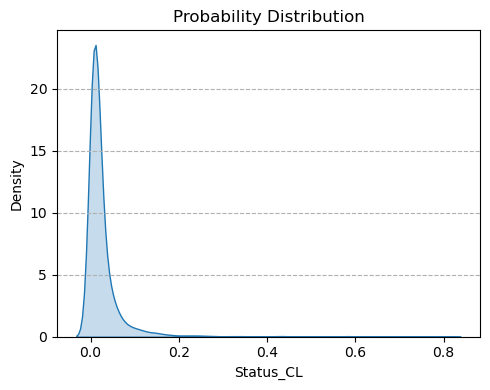

In [28]:
# plot probabilities
for target_class in target_classes:
    plot_probability_distribution(sub_data[target_class], target=target_class)